In [19]:
import pandas as pd
import time
import json
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
import scipy
import pickle as pkl
from collections import OrderedDict

# Figure 1

In [20]:
# Load data
with open('Data/symptom_to_num_ppl_dict.pkl', 'rb') as f:
    v3_symptoms_dicts = pkl.load(f)

# Set sample size after 3rd vaccine
v3_n = 1179

In [21]:
# Set parameters and helper function

plt.rcParams.update({'font.size': 22})

panel_a_labels = ['No\n Reaction', 'Mild\n Reaction', 'Severe\n Reaction']

severe_labels = ['Chills', 'Dyspnea', 'Confusion', 'Fever\n >38.9', 'Chest\n Pain']

mild_labels = ['Fatigue', 'Headache', 'Muscle\n Pain', 'Fever\n <=38.9', 'Vomiting',
               'Sore\n Throat', 'Cough', 'Cold', 'Diarrhea', 'Lymph', 'Fast\nHeartbeat',
               'Loss of\nTaste/Smell']

list_of_labels = [panel_a_labels, severe_labels, mild_labels]

severity_colors = [sns.color_palette('tab10')[7], # no reaction
                 sns.color_palette('tab10')[1], # mild reaction
                 sns.color_palette('tab10')[9]] # severe reaction

def beta(value,n):
    if value == 0:
        return [0,0]
    lower = value-scipy.stats.beta.ppf(0.025, value, n-value + 1, loc=0, scale=1)*n
    upper = scipy.stats.beta.ppf(0.975, value + 1, n-value, loc=0, scale=1)*n-value
    if lower > value:
        lower = value
    return [lower,upper]

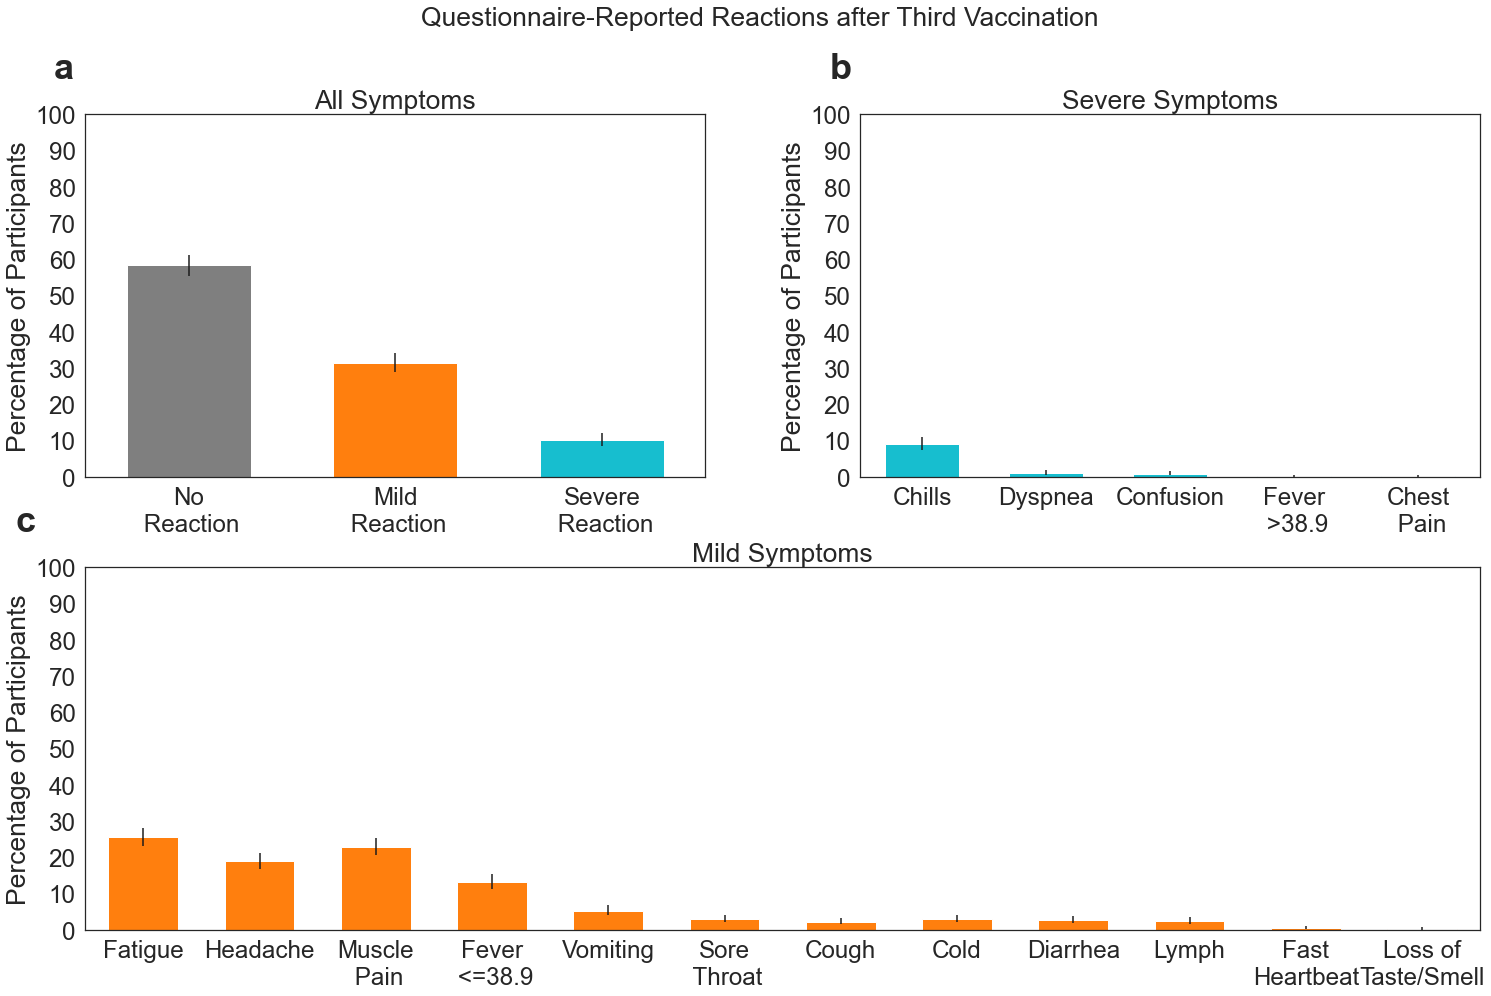

In [22]:
# Plot

titles = ["All Symptoms", "Severe Symptoms", "Mild Symptoms"]

fig = plt.figure(figsize=(25, 15))
rows = 2
columns = 2
grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)

for i in range(3):
    letter = chr(ord('a') + i)

    if i==0:
        ax=plt.subplot(grid[0,0])
    if i==1:
        ax=plt.subplot(grid[0,1])
    if i==2:
        ax=plt.subplot(grid[1,:])

    labels = list_of_labels[i]

    v3_g1_means = [v3_symptoms_dicts[i][j] / v3_n * 100 for j in labels]

    v3_g1_errs = np.array([beta(v3_symptoms_dicts[i][j], v3_n) for j in labels]).T / v3_n * 100

    x = np.arange(len(labels))  # the label locations
    width = 1

    if i==0:
        plt.bar(x, np.array(v3_g1_means), 0.6, yerr=v3_g1_errs, color=severity_colors)  
    if i==1:
        plt.bar(x, np.array(v3_g1_means), 0.6, yerr=v3_g1_errs, color=severity_colors[2]) 
    if i==2:
        plt.bar(x, np.array(v3_g1_means), 0.6, yerr=v3_g1_errs, color=severity_colors[1]) 

    ax.set_ylabel('Percentage of Participants')
    ax.set_title(titles[i])
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    pos = ax.get_position()
    ax.set_yticks(range(0,105,10))
    ax.text(x=-0.05, y=1.1, s=letter, fontweight="bold", size=36, transform=plt.gca().transAxes)

    ax.set_xlim(-0.5, len(labels)-0.5)

plt.suptitle("Questionnaire-Reported Reactions after Third Vaccination")
plt.show()



# Figure 2

In [23]:
reaction_pal = [sns.color_palette('tab10')[7], sns.color_palette('tab10')[1], sns.color_palette('tab10')[9]]
reactions = ['No Reaction', 'Mild Reaction', 'Severe Reaction']
reactions_in_df = ['no', 'mild', 'severe']

In [24]:
garmin_avg_hr = pd.read_csv('Data/garmin_avg_hr.csv')
garmin_avg_hrv = pd.read_csv('Data/garmin_avg_hrv.csv')

In [25]:

def plot_bar_groups(groups, pal, group_labels, series_labels, ylabel, figsize, fontsize):
    fig, ax = plt.subplots(figsize=figsize)

    X = np.arange(len(groups[0]))
    
    width = 0
    for i in range(len(groups)):
        group = groups[i]
        
        agg_mean = [g.mean() for g in group]
        agg_err = [scipy.stats.t.ppf(1-0.025, len(g) - 1)*g.std()/np.sqrt(len(g)) for g in group]
        print("Mean: %.3f, 95 CI: %.3f-%.3f" % (agg_mean[0], agg_mean[0] - agg_err[0], agg_mean[0] + agg_err[0]))
        print("Mean: %.3f, 95 CI: %.3f-%.3f" % (agg_mean[1], agg_mean[1] - agg_err[1], agg_mean[1] + agg_err[1]))

        plt.bar(X+width, agg_mean, 1/4, label=series_labels[i], color=pal[i])
        plt.errorbar(X+width,  agg_mean, yerr=agg_err, fmt='.k', ecolor='black')# capsize=8, 
        
        width += 1/4
        
    #plt.axhline(y=0, color='black', linestyle='dotted')
    
    ax.set_xticks(X+((len(groups)-1)/8))
    ax.set_xticklabels(group_labels, fontsize=fontsize)

    ax.tick_params(axis='y', labelsize=fontsize)
    
    plt.ylabel(ylabel, fontsize=fontsize)
    
    plt.legend(prop={'size': fontsize}, frameon=False, loc='upper left')
    
    plt.show()

Mean: 1.034, 95 CI: 0.558-1.511
Mean: 2.345, 95 CI: 1.390-3.299
Mean: 1.845, 95 CI: 1.303-2.387
Mean: 3.746, 95 CI: 2.621-4.871
Mean: 4.060, 95 CI: 2.798-5.322
Mean: 8.374, 95 CI: 5.711-11.037


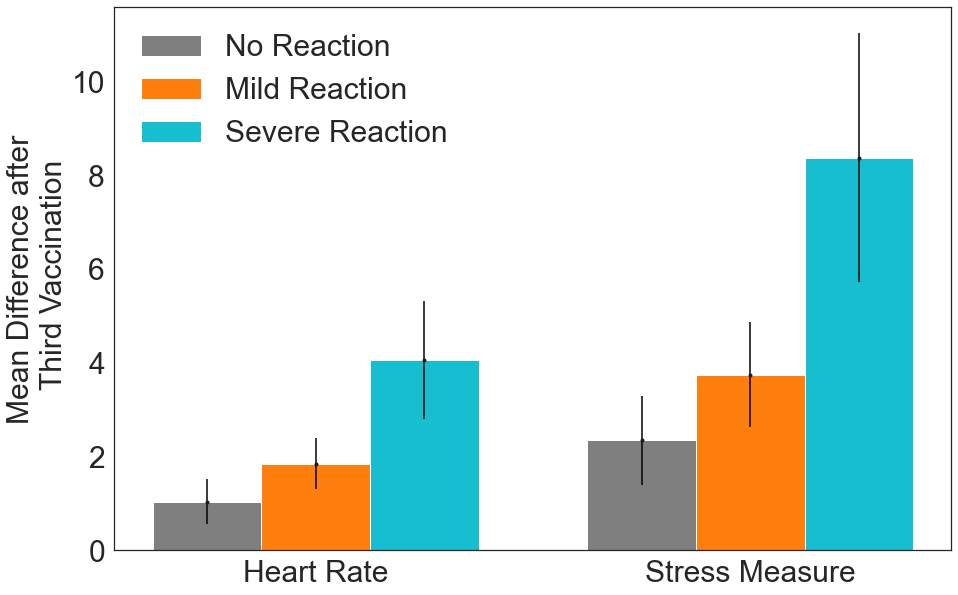

In [26]:
hr_reaction_dfs = [garmin_avg_hr[garmin_avg_hr['reaction']==r] for r in reactions_in_df]
hrv_reaction_dfs = [garmin_avg_hrv[garmin_avg_hrv['reaction']==r] for r in reactions_in_df]

groups = [
    [hr_reaction_dfs[i]['hr'], hrv_reaction_dfs[i]['hrv']] for i in range(3)
]


pal = reaction_pal

plot_bar_groups(groups, pal, ['Heart Rate', 'Stress Measure'], reactions, 'Mean Difference after\n Third Vaccination', (15, 10), 30)

# Figure 3

In [27]:
sns.set(font_scale=2.2,style='white')

In [28]:
garmin_timeseries_hr = pd.read_csv('Data/garmin_timeseries_hr.csv')
garmin_timeseries_hrv = pd.read_csv('Data/garmin_timeseries_hrv.csv')

In [29]:
hr_ts = garmin_timeseries_hr.groupby(['reaction', 'hour']).agg({'hr': ['mean', 'std', 'min', 'max', 'count']}).reset_index()
hrv_ts = garmin_timeseries_hrv.groupby(['reaction', 'hour']).agg({'hrv': ['mean', 'std', 'min', 'max', 'count']}).reset_index()

In [30]:
hr_ts.columns = [' '.join(col).strip() for col in hr_ts.columns.values]
hrv_ts.columns = [' '.join(col).strip() for col in hrv_ts.columns.values]

In [31]:
hr_ts['t'] = scipy.stats.t.ppf(1-0.025, hr_ts['hr count'] - 1)
hr_ts['ci_lower'] = hr_ts['hr mean'] - hr_ts['t']*hr_ts['hr std']/np.sqrt(hr_ts['hr count'])
hr_ts['ci_upper'] = hr_ts['hr mean'] + hr_ts['t']*hr_ts['hr std']/np.sqrt(hr_ts['hr count'])

hrv_ts['t'] = scipy.stats.t.ppf(1-0.025, hrv_ts['hrv count'] - 1)
hrv_ts['ci_lower'] = hrv_ts['hrv mean'] - hrv_ts['t']*hrv_ts['hrv std']/np.sqrt(hrv_ts['hrv count'])
hrv_ts['ci_upper'] = hrv_ts['hrv mean'] + hrv_ts['t']*hrv_ts['hrv std']/np.sqrt(hrv_ts['hrv count'])

In [32]:
dfs = [
    [hr_ts[hr_ts['reaction']=='no'], hrv_ts[hrv_ts['reaction']=='no']],
    [hr_ts[hr_ts['reaction']=='mild'], hrv_ts[hrv_ts['reaction']=='mild']],
    [hr_ts[hr_ts['reaction']=='severe'], hrv_ts[hrv_ts['reaction']=='severe']],
]

In [33]:

def plot_single_subfigure(ax, agg_avg, agg_ci_lower, agg_ci_upper, letter, xlabel, ylabel, x_ticks, yticks, color, figsize, fontsize, with_ci):
    x_axis = range(len(agg_avg))
    
    ax.set_xlabel(xlabel, fontsize=40)
    #axs[i,j].set_ylabel(ylabel, fontsize=fontsize)

    ax.axhline(y=0, color='black', linestyle='dotted')
    if len(agg_avg)>24:
        for k in range(len(agg_avg)//24+1):
            ax.axvline(x=k*24, color='red', linestyle='dotted')

    if with_ci:
        ax.fill_between(x_axis, y1=agg_ci_lower, y2=agg_ci_upper, color=color, alpha=.3)
    ax.plot(x_axis, agg_avg, linestyle='-', color=color)
    
    ax.margins(x=0)
    ax.set_xticks(x_ticks)
    ax.set_yticks(yticks)
    ax.set_title(letter, x=-0.04, y=1.05, fontweight="bold", fontsize=fontsize*1.5)
    
def plot_all_subfigures(dfs, col_labels, xlabel, ylabels, xticks, ytickss, figsize, fontsize, pal, with_ci):
    n_rows = 3
    n_cols = 2
    
    cols = col_labels
    if n_rows == 1:
        squeeze = True
    else:
        squeeze = False
        
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, facecolor='white', squeeze=squeeze)

    if n_rows==1:
        axs = [axs]

    for i in range(n_rows):
        for j in range(n_cols):
            if i==n_rows-1: 
                adj_xlabel = xlabel
            else:
                adj_xlabel = ''

            if j==0:
                ylabel = ylabels[i] 
            else:
                ylabel = ''
            
            if j == 0:
                agg_cnt = dfs[i][j]['hr count'].values
                agg_avg = dfs[i][j]['hr mean'].values
                agg_min = dfs[i][j]['hr min'].values
                agg_max = dfs[i][j]['hr max'].values
            if j == 1:
                agg_cnt = dfs[i][j]['hrv count'].values
                agg_avg = dfs[i][j]['hrv mean'].values
                agg_min = dfs[i][j]['hrv min'].values
                agg_max = dfs[i][j]['hrv max'].values
            agg_ci_lower = dfs[i][j]['ci_lower'].values
            agg_ci_upper = dfs[i][j]['ci_upper'].values
            letter = chr(ord('a') + j + n_cols*i)

            plot_single_subfigure(axs[i][j], agg_avg, agg_ci_lower, agg_ci_upper, letter, adj_xlabel, ylabels[i], xticks, ytickss[j], pal[i], figsize, fontsize, with_ci)

    pad = 5 # in points

    for i in range(n_cols):
        axs[0][i].annotate(cols[i], xy=(0.5, 1.05), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')#,fontsize=int(fontsize*1.7))#,fontweight="bold"

    for j in range(n_rows):
        axs[j][0].annotate(ylabels[j], xy=(0, 0.5), xytext=(-axs[j][0].yaxis.labelpad - pad -30, 0),
                    xycoords=axs[j][0].yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center',rotation=90)#,fontsize=int(fontsize*1.7)) #fontsize=20
    
    fig.tight_layout()
    fig.subplots_adjust(left=0.05, top=1)
    plt.show()

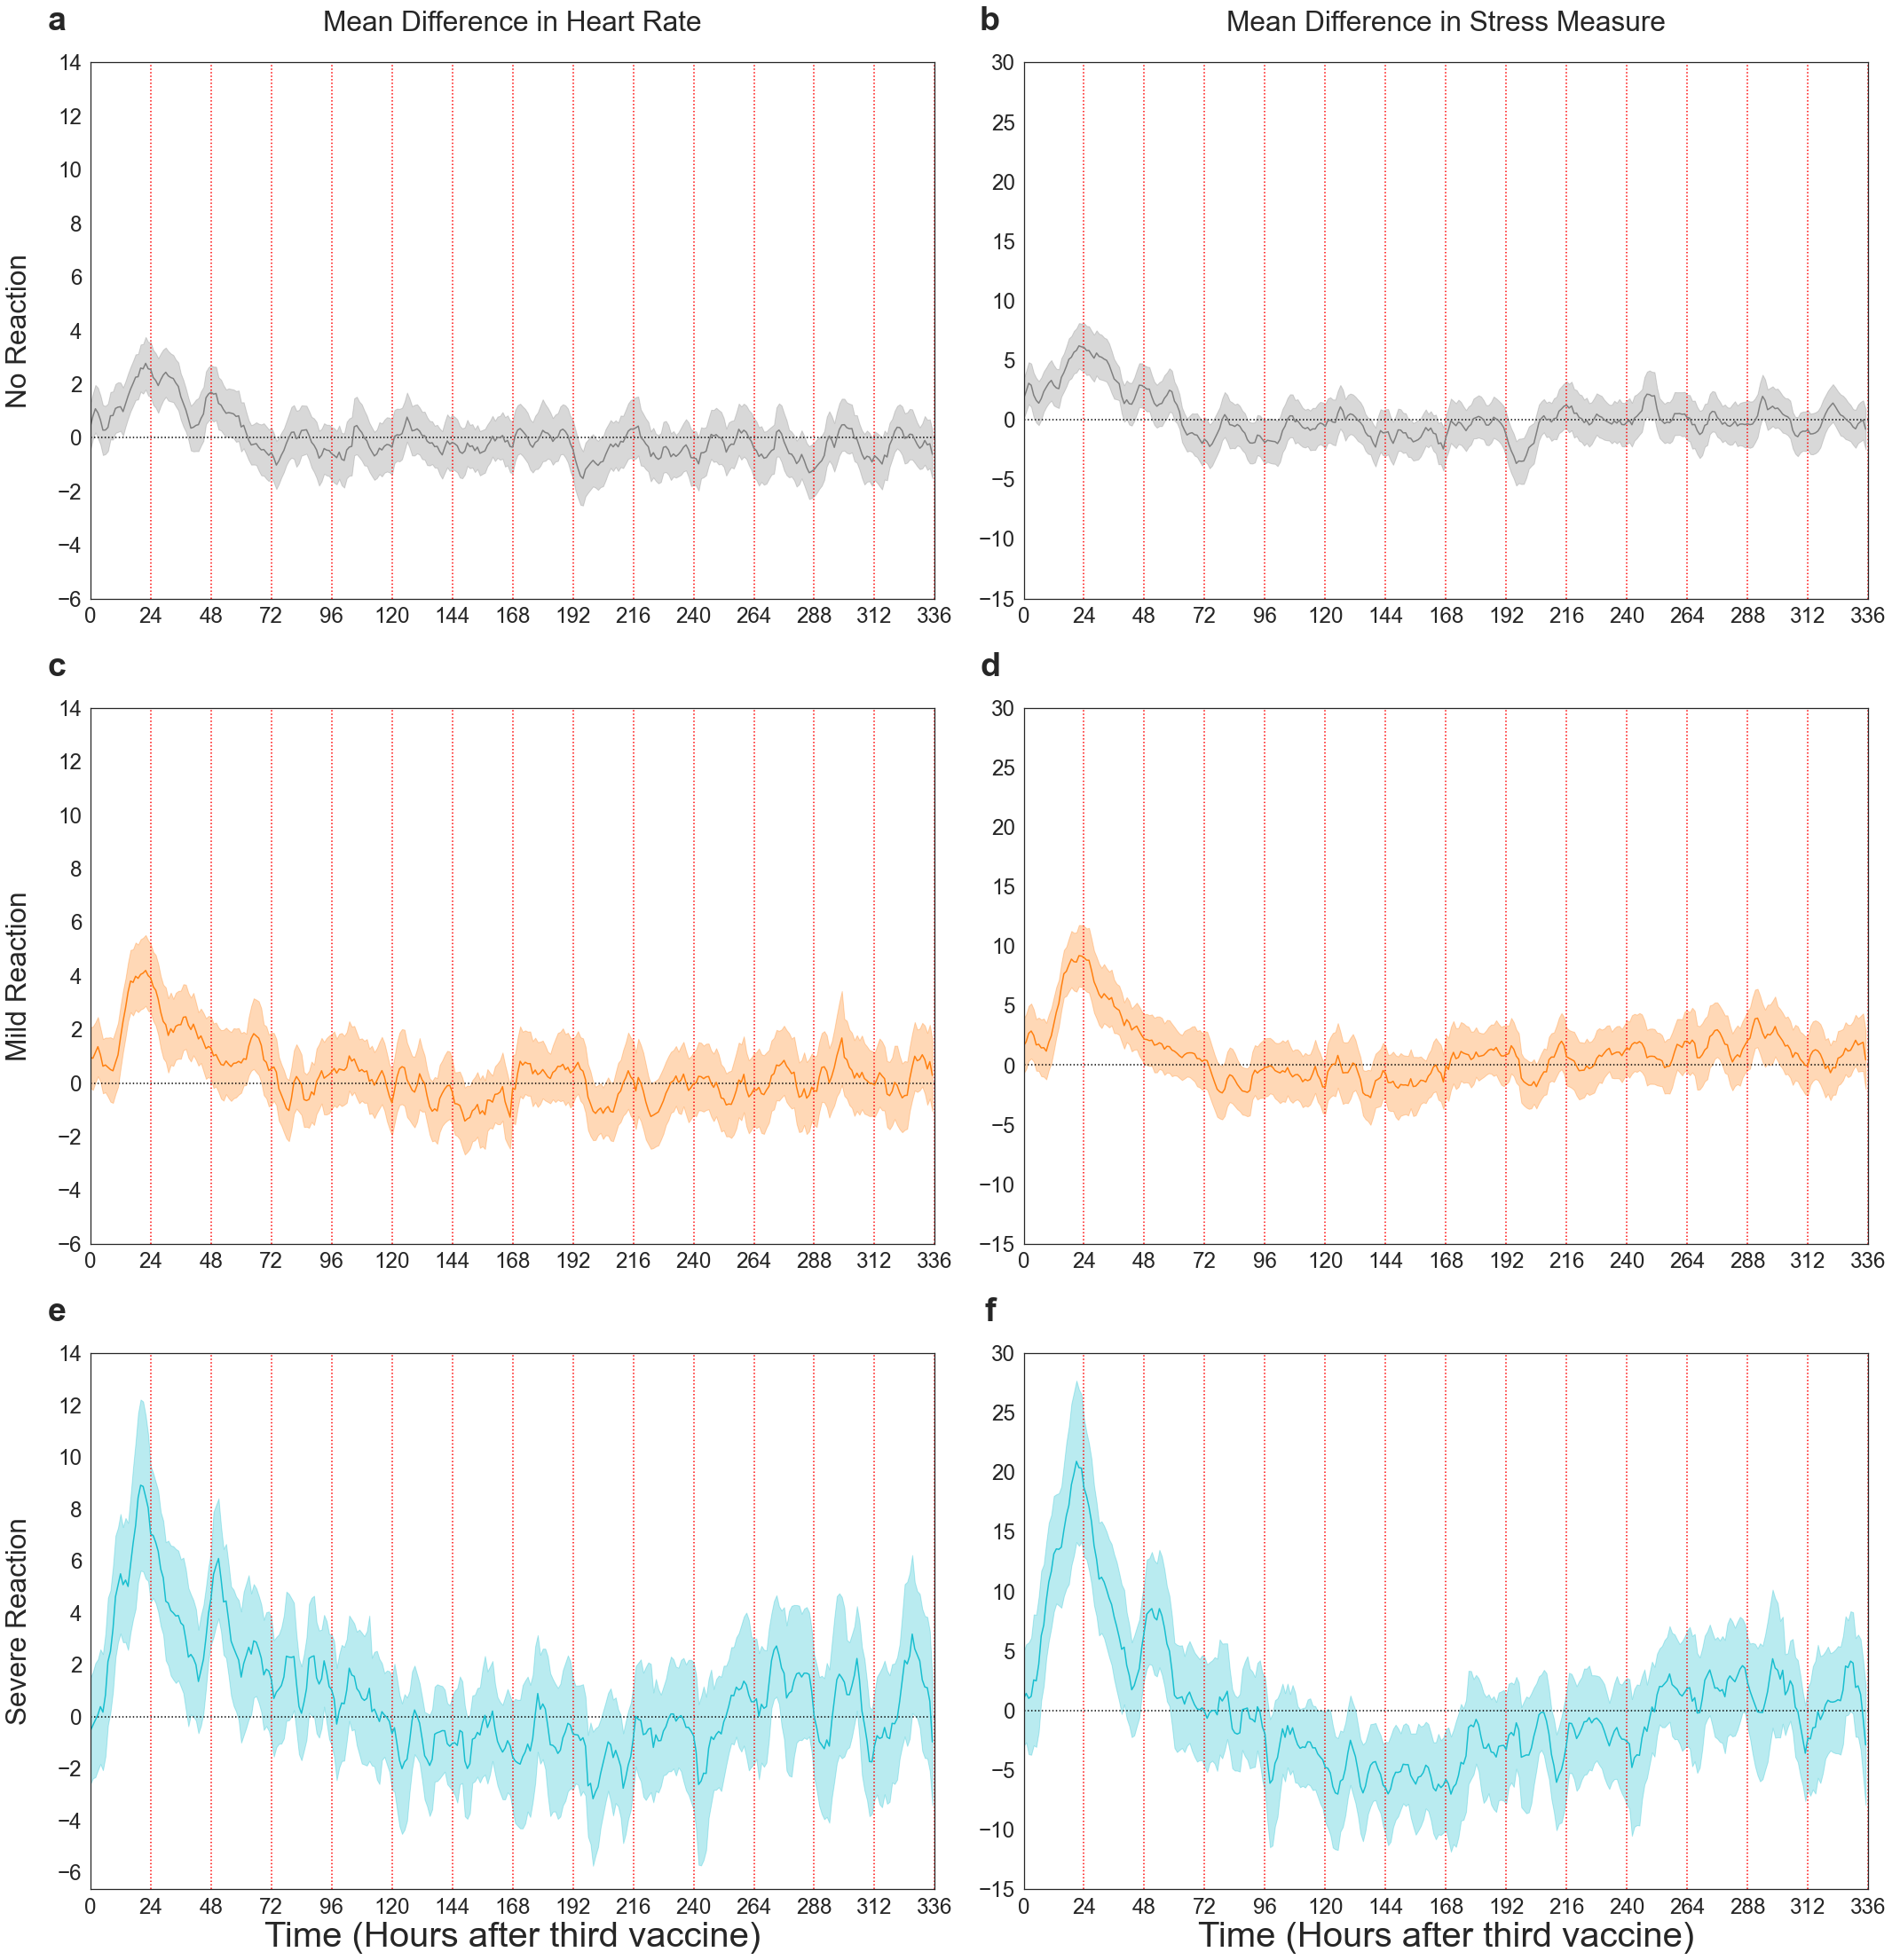

In [34]:
col_labels = ['Mean Difference in Heart Rate', 'Mean Difference in Stress Measure']

xlabel = 'Time (Hours after third vaccine)'
ylabels = ['No Reaction', 'Mild Reaction', 'Severe Reaction']

xticks = range(0, 14*24+1, 24)
ytickss =  [np.arange(-6, 15, 2), np.arange(-15, 31, 5)]

pal = reaction_pal

figsize = (15*2, 10*3)
fontsize = 25

plot_all_subfigures(dfs, col_labels, xlabel, ylabels, xticks, ytickss, figsize, fontsize, pal, True)